In [2]:
import numpy as np
import pandas as pd
import polarDensity_helper as pc
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
plt.rcParams['axes.grid'] = False 

# Important User Settings:

In [3]:
root = Path("/Users/ezry/Projects/ELIC_PE_PG/trajectory_version")
chains_groups = ["POPE", "POPG"]
lipids = chains_groups

In [4]:
enrich = True

# get files to use

file_list = []
for lip in lipids:
    toadd = list(root.glob(f"{lip}.dat*avg.dat") )
    file_list = np.append(file_list,toadd)

leaflets = ['low', 'upp']

In [5]:
enrichments = pd.DataFrame(index=chains_groups, columns=leaflets)
counts = pd.DataFrame(index=chains_groups, columns=leaflets)

idx = 0
for fl in file_list:
    if idx == 0:
        rad, dr, dth, theta, radius, frames, Ntheta = pc.Coord_Get(fl)

    filename = fl.name

    tmp_chain = filename.split('.')[0]
    tmp_nm = filename.split('.')[2]

    # This is a hack. The above part does not have a "flexible"
    # method to consider sim type (a, b ...)
    idx+=1
    toadd = np.loadtxt(fl, skiprows=1)
    toadd = toadd[:,3:-1]
    counts.at[tmp_chain,tmp_nm] = toadd
    enrichments.at[tmp_chain,tmp_nm] = pc._analysis_call_(fl, radius, dr, dth, frames, enrich=enrich)


In [6]:
# Optional helix locations
try:
    helices_lwr = np.loadtxt(root.joinpath("Protein_coords_lwr.dat"))
    helices_upr = np.loadtxt(root.joinpath("Protein_coords_upr.dat"))
except FileNotFoundError:
    helices_lwr = None
    helices_upr = None
    print("Protein coordinates not found")

In [89]:
def polar_plot(data_in, theta, radius, chains_groups, helices_lwr=None, helices_upr=None, vmax=2, vmid=1, vmin=0, colorbychain=True, dr=5):
	# plots densities
	# data_in = array/list of density data
	# theta, radius = arrays of position bins
	# chains_groups = old name, really lipids to plot

    data_in = pc.sum_reps(data_in)
    fig = plt.figure(figsize=(20,20))
    gs1=gridspec.GridSpec(len(chains_groups),2,wspace=.15, hspace=0.15)
    plt.rcParams.update({'font.size': 10})
    norm1 = pc.MidpointNormalize(midpoint=vmid,vmin=vmin,vmax=vmax)
    cmap = plt.cm.RdBu#PuOr
    cmap.set_bad(color='black')
    grid = 0
    #chains_up, chains_lo = prot_coord()
    #sub = ["g",'m','grey','green','cyan']#original

    #  orange   light blue   green      amber      blue       red       purple 
    #"#E69F00"  "#56B4E9"  "#009E73"  "#F5C710"  "#0072B2"  "#D55E00"  "#CC79A7" 
    sub = ["#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7" ]

    for cg in chains_groups:
        for leaf in data_in.columns:
            ax = plt.subplot(gs1[grid],projection="polar")
            # ax.grid(False)
            thetas = np.unique(theta)
            dt = thetas[1]-thetas[0]
            ax.set_xticks(thetas)
            ax.set_xticklabels(np.array(thetas/dt).astype(int))
            #ax.set_xticklabels([])
            #ax.set_yticklabels([])

            # Ntheta = np.shape(theta)[1]
            # for i in np.arange(np.shape(theta)[0]):
            #     for j in np.arange(Ntheta):
            #         azimuth = theta[i,j]
            #         distance = radius[i,j]
            #         the_label = f"({np.round(azimuth,1)},{np.round(distance,0)})"
            #         ax.text(azimuth,distance,the_label, zorder=2, fontsize=4, rotation=np.rad2deg(azimuth)-90)

            toplot = data_in.at[cg,leaf]
            s = ax.pcolormesh(theta, 
                              radius, 
                              toplot,
                              cmap=cmap,
                              norm=norm1,
                              zorder=0,
                              edgecolors='none',
                              linewidth=0,
                              )
            s.set_edgecolor('face')
            if grid%2==0:
                ax.set_ylabel(cg)
            if grid < 2:
                ax.set_title(leaf)
                

            grid = grid + 1
            
            if leaf=="Outer":
                helices = helices_upr
            else:
                helices = helices_lwr

            if helices is not None:
                if len(np.shape(helices))==1:
                    helices = np.reshape(helices, (1,len(helices)))
                for i,pro in enumerate(helices[:]):
                    if colorbychain:
                        colors = sub[i]
                    else:
                        colors = sub[:len(pro[::2])]
                    ax.scatter(np.deg2rad(pro[1::2]),
                                pro[::2],
                                color=colors,
                                linewidth=6,
                                zorder=1, 
                                s=np.shape(data_in)[0]*10,
                                )


    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.21, .89, 0.5, 0.008])
    fig.colorbar(s, cax=cbar_ax,ticks=np.linspace(vmin,vmax,5),orientation="horizontal")

    #plt.tight_layout()
    return fig, fig.axes

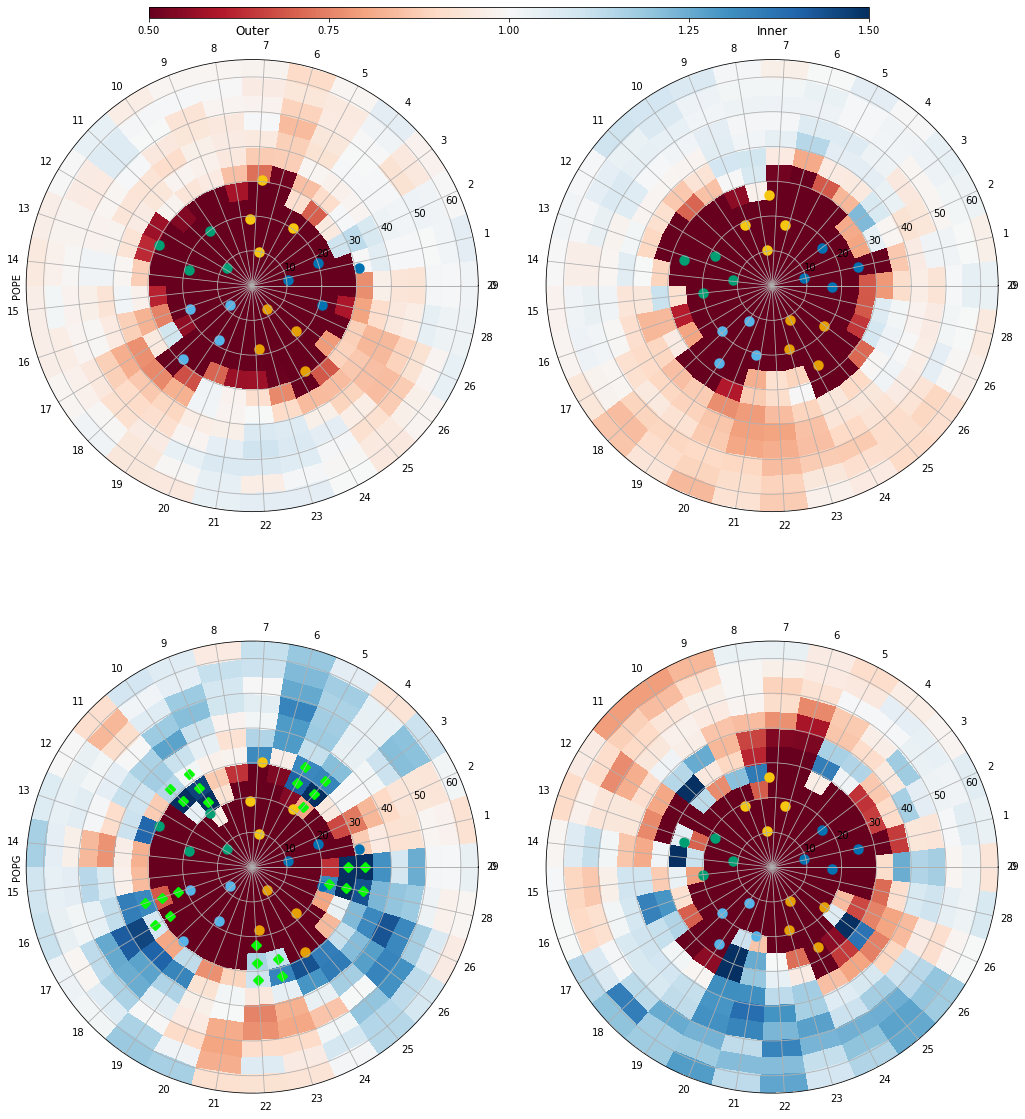

In [130]:
fig, axes = polar_plot(enrichments, theta, radius, chains_groups, helices_lwr, helices_upr, colorbychain=True, vmin=0.5, vmax=1.5, vmid=1)
axes[2].scatter(thetas[5:30:6], np.repeat(27.5,5), color="lime", marker="x", linewidth=7)
axes[2].scatter(thetas[4:30:6], np.repeat(27.5,5), color="lime", marker="x", linewidth=7)
axes[2].scatter(thetas[4:30:6], np.repeat(32.5,5), color="lime", marker="x", linewidth=7)
axes[2].scatter(thetas[5:30:6], np.repeat(32.5,5), color="lime", marker="x", linewidth=7)
axes[2].scatter(thetas[4:30:6], np.repeat(22.5,5), color="lime", marker="x", linewidth=7)
plt.savefig("enrichment_site_indicated.pdf")
plt.show()